# Verdiepende casus
In mijn verdiepende casus ga ik kijken of een behandeling effectief gaat zijn aan de hand van afbeelding van tumoren. <Br>
Mijn data bestaat uit ROI van 512 x 512 met een kleuring of een specifieke cel kleuring zoals CD8+ of PCK. <Br>
https://www.cancerimagingarchive.net/collection/hnscc-mif-mihc-comparison/?utm_source=chatgpt.com <br>
Dezelfde ROI heeft meerdere kleuringen, zoals een Hematoxyline kleuring CD8+ en segmentation. <Br>
Deze ga ik alle 3 overlayen om zo de AI te trainen om in het vervolg zelf de CD8 cellen eruit te halen. <br>
Ik ga vanwege de complexiteit alleen met met de CD8, hema en segmentation fotos werken. <Br>
Elke case heeft meerdere regions (T,M,S) <br>
T = tumorcore <br>
M = tumor margin <br>
S = stroma area <br>
elke region heeft daarbinnen dan weer 4 areas <br>
0_0 <br>
1_0 <br>
1_1 <br>
0_1 <br>
Ik ga alle regions en areas gebruiken van case 1 t/m 6. Dit zijn 591 fotos <br>
De Hematoxyline layer wordt gebruikt om nuclei te locaten <Br>
De CD8 layer om te zeggen welke nuclei bij CD8 hoort op basis van intensiteit van het signal <br>
De segmentation om duidelijke te maken waar de celgrenzen zijn en een outline te geven, blauw op zwart. <br>
Hierna ga ik zo alle 3 overlayen hiervoor ga ik Convolutional Neural Network (CNN) gebruiken <Br> 
Hierna ga ik parameters meegeven aan wanneer een behandeling effectief is op basis van het aantal CD8 cellen gelokaliseerd <Br>
Ik weet dat dit arbitrair is en natuurlijk niet is hoe het echt werkt. Maar dit is wel een begin <br>



# EDA

In [38]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Modules inladen 

In [55]:
DATA_FOLDER = "data"
TRAIN_DATA_FOLDER = "train_data"

# kijken of folder bestaat 
if not os.path.exists(DATA_FOLDER):
    raise FileNotFoundError(f"Data folder not found: {DATA_FOLDER}")

# Nieuwe folder maken 
if not os.path.exists(TRAIN_DATA_FOLDER):
    os.makedirs(TRAIN_DATA_FOLDER)

# de fotos die we niet willen niet meenemen 
exclude_terms = ["CD3", "DAPI", "FoxP3", "PanCK"]

# bij houden wat er gecombineerd is 
processed_combinations = set()

# door de files loopen 
for case_file in os.listdir(DATA_FOLDER):
    # allen toevoegen als het niet excluded terms zijn 
    if not any(exclude_term in case_file for exclude_term in exclude_terms):
        # split op case area en region 
        parts = case_file.split("_")
        if len(parts) >= 4:
            case = parts[0]  
            region = parts[1]  
            area = parts[2] + "_" + parts[3].split(".")[0]  # samen voegen 

            # folder maken 
            subfolder_name = f"{case}_{region}_{area}"

            # skippen als die al bestaat 
            if subfolder_name in processed_combinations:
                continue

            processed_combinations.add(subfolder_name)

            # folder voor uniue area maken 
            subfolder_path = os.path.join(TRAIN_DATA_FOLDER, subfolder_name)
            if not os.path.exists(subfolder_path):
                os.makedirs(subfolder_path)

            # de 3 gewilde files zoeken 
            for suffix in ["CD8", "hematoxylin", ""]:
                # maak de file 
                expected_file = f"{case}_{region}_{area}"
                if suffix:
                    expected_file += f"_{suffix}.png"
                else:
                    expected_file += ".png"

                # move de file naar de juiste folder 
                source_path = os.path.join(DATA_FOLDER, expected_file)
                if os.path.exists(source_path):
                    destination_path = os.path.join(subfolder_path, expected_file)
                    
                    # sla de images op 
                    image = cv2.imread(source_path, cv2.IMREAD_UNCHANGED)  #
                    if image is not None:
                        cv2.imwrite(destination_path, image)
                        print(f"Moved {expected_file} to {subfolder_name}")
                    else:
                        print(f"Failed to load image: {source_path}")

print(f"Organized data into {len(processed_combinations)} unique folders.")

# checken of het goed is gegaan
subfolders = os.listdir(TRAIN_DATA_FOLDER)
print(f"Subfolders in 'train_data': {subfolders}")


Moved Case1_M1_0_0_CD8.png to Case1_M1_0_0
Moved Case1_M1_0_0_hematoxylin.png to Case1_M1_0_0
Moved Case1_M1_0_0.png to Case1_M1_0_0
Moved Case1_M1_0_1_CD8.png to Case1_M1_0_1
Moved Case1_M1_0_1_hematoxylin.png to Case1_M1_0_1
Moved Case1_M1_0_1.png to Case1_M1_0_1
Moved Case1_M1_1_0_CD8.png to Case1_M1_1_0
Moved Case1_M1_1_0_hematoxylin.png to Case1_M1_1_0
Moved Case1_M1_1_0.png to Case1_M1_1_0
Moved Case1_M1_1_1_CD8.png to Case1_M1_1_1
Moved Case1_M1_1_1_hematoxylin.png to Case1_M1_1_1
Moved Case1_M1_1_1.png to Case1_M1_1_1
Moved Case1_M2_0_0_CD8.png to Case1_M2_0_0
Moved Case1_M2_0_0_hematoxylin.png to Case1_M2_0_0
Moved Case1_M2_0_0.png to Case1_M2_0_0
Moved Case1_M2_0_1_CD8.png to Case1_M2_0_1
Moved Case1_M2_0_1_hematoxylin.png to Case1_M2_0_1
Moved Case1_M2_0_1.png to Case1_M2_0_1
Moved Case1_M2_1_0_CD8.png to Case1_M2_1_0
Moved Case1_M2_1_0_hematoxylin.png to Case1_M2_1_0
Moved Case1_M2_1_0.png to Case1_M2_1_0
Moved Case1_M2_1_1_CD8.png to Case1_M2_1_1
Moved Case1_M2_1_1_hematox

## Data inlezen
In de code hierboven laad ik de data in. <br>
Ik heb de CD8, hema, en segmentation fotos in een 'train_data' mapje gedaan. <Br>
Omdat de foto's "segmentation" geen suffix heeft heb ik het zo gedaan:<br>
Ik heb alle fotos die niet de naam "CD3", "DAPI", "FoxP3", "PanCK" hebben in de train_data folder gestopt <br>
Zo isoleer ik alleen de CD8, hema en seg. <br>
Verder heb ik ervoor gekozen om subfolders te maken van elke area van elke region per case.<br>
Dus maar 3 fotos per folder. Dit heb ik gedaan om straks de overlay stap van de 3 fotos makkelijker te maken. <br>




In [56]:

# path naar folders 
TRAIN_DATA_FOLDER = "train_data"
TRAIN_IMAGES_FOLDER = "train_images"

# nieuwe maken als die nog niet bestaat 
if not os.path.exists(TRAIN_IMAGES_FOLDER):
    os.makedirs(TRAIN_IMAGES_FOLDER)
# fotos en labels 
images = []
labels = []

# train data moet bestaat anders error 
if not os.path.exists(TRAIN_DATA_FOLDER):
    raise FileNotFoundError(f"Train data folder not found: {TRAIN_DATA_FOLDER}")


# submaken door loopen 
for root, subdirs, files in os.walk(TRAIN_DATA_FOLDER):
    print(f"Files in {root}: {files}")
    file_groups = {}

    # files groeperen bij area 
    for file_name in files:
        if file_name.endswith(".png"):
            # if statements voor de 3 gewilde groepen 
            if "_CD8" in file_name:
                base_name = file_name.replace("_CD8.png", "")
                file_groups.setdefault(base_name, {})["CD8"] = os.path.join(root, file_name)
            elif "_hematoxylin" in file_name:
                base_name = file_name.replace("_hematoxylin.png", "")
                file_groups.setdefault(base_name, {})["Hematoxylin"] = os.path.join(root, file_name)
            else:
                base_name = file_name.replace(".png", "")
                file_groups.setdefault(base_name, {})["Segmentation"] = os.path.join(root, file_name)

    # kleine debug 
    for base_name, paths in file_groups.items():
        print(f"Grouped files for {base_name}: {paths}")

    # groep processen 
    for base_name, files in file_groups.items():
        cd8_path = files.get("CD8")
        hema_path = files.get("Hematoxylin")
        segm_path = files.get("Segmentation")

        # kijken of in alle mappen er 3 zitten 
        missing_files = []
        if not cd8_path:
            missing_files.append("CD8")
        if not hema_path:
            missing_files.append("Hematoxylin")
        if not segm_path:
            missing_files.append("Segmentation")
        # error message als dat niet zo is 
        if missing_files:
            print(f"Skipping incomplete set: {base_name} (Missing: {', '.join(missing_files)})")
            continue

        # images laden 
        cd8_image = cv2.imread(cd8_path, cv2.IMREAD_GRAYSCALE)
        hema_image = cv2.imread(hema_path, cv2.IMREAD_GRAYSCALE)
        segm_image = cv2.imread(segm_path, cv2.IMREAD_UNCHANGED)  # deze niet grayscalen omdat ie blauw is 

        # kleine debug 2 
        if cd8_image is None:
            print(f"Failed to load CD8 image: {cd8_path}")
        if hema_image is None:
            print(f"Failed to load Hematoxylin image: {hema_path}")
        if segm_image is None:
            print(f"Failed to load Segmentation image: {segm_path}")

        if cd8_image is None or hema_image is None or segm_image is None:
            continue

        # kijken of het formaat wel 512 bij 512 is 
        if cd8_image.shape != (512, 512) or hema_image.shape != (512, 512) or segm_image.shape[:2] != (512, 512):
            print(f"Image size mismatch for: {base_name}")
            continue

        # combine de 3 images 
        combined_image = np.zeros((512, 512, 3), dtype=np.uint8)
        combined_image[:, :, 0] = segm_image[:, :, 0] if segm_image.ndim == 3 else segm_image  # Blauw
        combined_image[:, :, 1] = hema_image  # Groen
        combined_image[:, :, 2] = cd8_image  # Rood 

        # combined images opslaan 
        combined_filename = f"{base_name}_combined.png"
        combined_image_path = os.path.join(TRAIN_IMAGES_FOLDER, combined_filename)
        cv2.imwrite(combined_image_path, combined_image)
        print(f"Saved combined image: {combined_filename}")

        # toevoegen aan lijst 
        images.append(combined_image)
        labels.append(1)  # dummy label voor nu 
# print alles 
print(f"Loaded {len(images)} combined images.")
print(f"Files in 'train_images' folder: {os.listdir(TRAIN_IMAGES_FOLDER)}")


Files in train_data: []
Files in train_data\Case1_M1_0_0: ['Case1_M1_0_0.png', 'Case1_M1_0_0_CD8.png', 'Case1_M1_0_0_hematoxylin.png']
Grouped files for Case1_M1_0_0: {'Segmentation': 'train_data\\Case1_M1_0_0\\Case1_M1_0_0.png', 'CD8': 'train_data\\Case1_M1_0_0\\Case1_M1_0_0_CD8.png', 'Hematoxylin': 'train_data\\Case1_M1_0_0\\Case1_M1_0_0_hematoxylin.png'}
Saved combined image: Case1_M1_0_0_combined.png
Files in train_data\Case1_M1_0_1: ['Case1_M1_0_1.png', 'Case1_M1_0_1_CD8.png', 'Case1_M1_0_1_hematoxylin.png']
Grouped files for Case1_M1_0_1: {'Segmentation': 'train_data\\Case1_M1_0_1\\Case1_M1_0_1.png', 'CD8': 'train_data\\Case1_M1_0_1\\Case1_M1_0_1_CD8.png', 'Hematoxylin': 'train_data\\Case1_M1_0_1\\Case1_M1_0_1_hematoxylin.png'}
Saved combined image: Case1_M1_0_1_combined.png
Files in train_data\Case1_M1_1_0: ['Case1_M1_1_0.png', 'Case1_M1_1_0_CD8.png', 'Case1_M1_1_0_hematoxylin.png']
Grouped files for Case1_M1_1_0: {'Segmentation': 'train_data\\Case1_M1_1_0\\Case1_M1_1_0.png', 'C

## Overlay van Hematoxyline, CD8 en segmentation
hierboven staat de code over hoe de 3 fotos (hema, cd8 en seg) zijn overlayed om samen 1 foto te maken. <br>
Ik heb ervoor gekozen om ze te overlayen met blauw, groen en rood. <br>
Blauw is de segmentation image <br>
Groen is de hematoxyline image <br>
Rood is de CD8 image <br>
Zo kan het model straks goed de rode puntjes in de overlay image zien en tellen. 


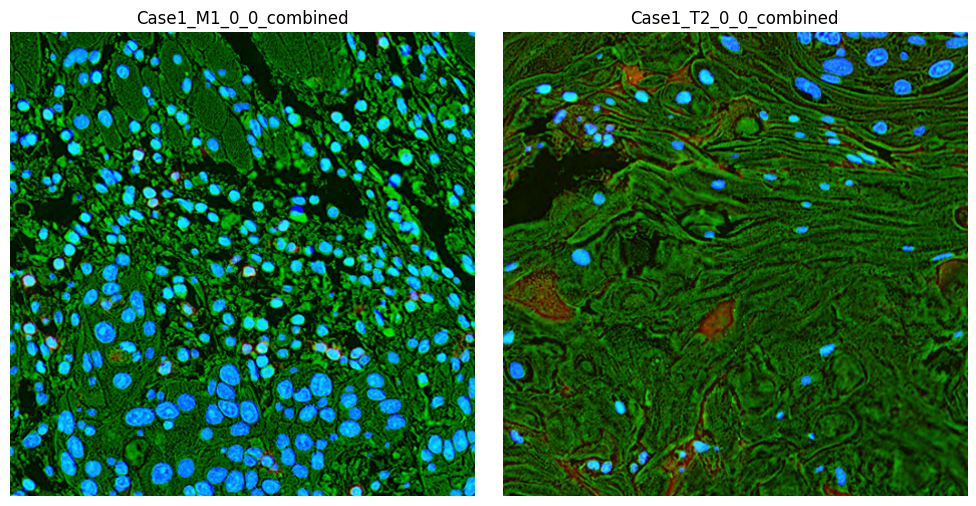

In [ ]:
# path naar de afbeeldingen 
image1_path = "train_images/Case1_M1_0_0_combined.png"
image2_path = "train_images/Case1_T2_0_0_combined.png"

# Laad de afbeeldingen in 
image1 = mpimg.imread(image1_path)
image2 = mpimg.imread(image2_path)

# Visualiseer de afbeeldingen
plt.figure(figsize=(10, 5))

# Eerste afbeelding
plt.subplot(1, 2, 1)
plt.imshow(image1)
plt.title("Case1_M1_0_0_combined")
plt.axis("off")

# Tweede afbeelding
plt.subplot(1, 2, 2)
plt.imshow(image2)
plt.title("Case1_T2_0_0_combined")
plt.axis("off")
# plot ze 
plt.tight_layout()
plt.show()


## overlayed foto
Hierboven zijn 2 overlayed fotos afgebeeld.<br>
Waar ik het model op ga trainen is het tellen van de rode cellen die je in de linker afbeelding weinig kan zien <br>
Maar in de rechter afbeelding meer kan zien <br>


In [57]:
import cv2
import numpy as np
import os

# Functie om de cd8 cellen te tellen 
def count_cd8_cells_from_overlay(overlay_image_path):
    # Laad de afbeelding in 
    img = cv2.imread(overlay_image_path)
    
    # Split de afbeelding in de kleurkanalen blauw, groen en rood 
    blue_channel, green_channel, red_channel = cv2.split(img)
    
    # drempel waarde zeggen, ik heb 100 voor nu 
    _, red_threshold = cv2.threshold(red_channel, 100, 255, cv2.THRESH_BINARY)
    
    # masker maken die een paar andere voorwaarden geeft 
    red_mask = (red_threshold > 100) & (green_channel < 50) & (blue_channel < 50)
    
    # Tel het aantal pixel die volgens de voorwaarden rood genoeg zijn en dus cd8 cel zijn 
    cell_count = np.sum(red_mask)
    
    return cell_count

# Path naar de map met de overlay afbeeldingen 
image_dir = "train_images"  

# Controleer of de map bestaat
if not os.path.exists(image_dir):
    print(f"De map '{image_dir}' bestaat niet. Controleer het pad.")
else:
    print(f"Bezig met het verwerken van afbeeldingen in '{image_dir}'...")

    # Lijst om resultaten op te slaan
    results = []

    # loop door alles 
    for filename in os.listdir(image_dir):
        if filename.endswith("_combined.png"):  # controleer of het combined is 
            file_path = os.path.join(image_dir, filename)
            print(f"Bezig met verwerken: {file_path}")
            
            # call de functie die dus telt 
            cell_count = count_cd8_cells_from_overlay(file_path)
            
            # Voeg resultaat toe aan de lijst
            results.append(f"Aantal CD8+ cellen in {filename}: {cell_count}")

    # Print alles 
    for result in results:
        print(result)


Bezig met het verwerken van afbeeldingen in 'train_images'...
Bezig met verwerken: train_images\Case1_M1_0_0_combined.png
Bezig met verwerken: train_images\Case1_M1_0_1_combined.png
Bezig met verwerken: train_images\Case1_M1_1_0_combined.png
Bezig met verwerken: train_images\Case1_M1_1_1_combined.png
Bezig met verwerken: train_images\Case1_M2_0_0_combined.png
Bezig met verwerken: train_images\Case1_M2_0_1_combined.png
Bezig met verwerken: train_images\Case1_M2_1_0_combined.png
Bezig met verwerken: train_images\Case1_M2_1_1_combined.png
Bezig met verwerken: train_images\Case1_M3_0_0_combined.png
Bezig met verwerken: train_images\Case1_M3_0_1_combined.png
Bezig met verwerken: train_images\Case1_M3_1_0_combined.png
Bezig met verwerken: train_images\Case1_M3_1_1_combined.png
Bezig met verwerken: train_images\Case1_S2_0_0_combined.png
Bezig met verwerken: train_images\Case1_S3_0_0_combined.png
Bezig met verwerken: train_images\Case1_S3_0_1_combined.png
Bezig met verwerken: train_images\Case